<a href="https://colab.research.google.com/github/lhartson03/psu_quants/blob/main/mpt_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
yf.pdr_override()

In [ ]:
def load_us_stock_data(tickerList, start_date):
  stocks_data = pd.DataFrame()
  stocks_data = pdr.get_data_yahoo(tickerList, start = start_date, progress = False)['Adj Close']
  return stocks_data

In [ ]:
# load Data
tickers = ['IBM','SPY','GLD']
priceData = pd.DataFrame()
priceData = load_us_stock_data(tickers,datetime(2002,7,30))
# calculate daily log return
pChangeDoD = priceData.pct_change().apply(lambda x: np.log(1+x))
pChangeDoD.dropna(axis = 0, inplace = True)
# calculate variance
pChangeDoD.var()*250
# cacluate standar deviation
sd = pChangeDoD.std()*np.sqrt(250)
# caclulate expected return
e_r = pChangeDoD.mean()*250

<Axes: >

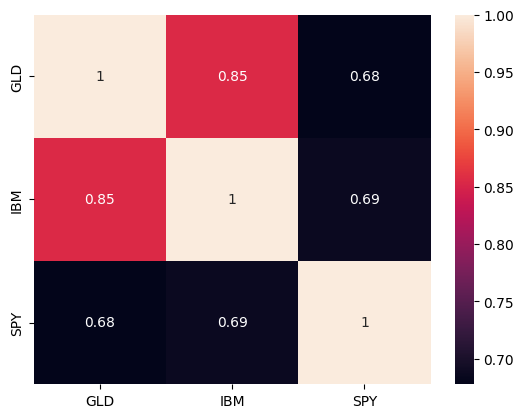

In [ ]:
cov_matrix = pChangeDoD.cov()
sns.heatmap(priceData.corr(),annot=True)

In [ ]:
# Sampling from a dirichlet distribution
p_ret = []
p_weights = []
p_vol = []

# set no. of assets and portfolios to simulate
num_assets = len(priceData.columns)
num_portfolios = 50000

# for each random portfolio, find the return and volatility
for portfolio in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    # ScaleS the weights to fit your desired range, e.g., -1 to 2
    min_weight = -0.5
    max_weight = 1.5
    weights = min_weight + (max_weight - min_weight) * weights
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights,e_r)
    p_ret.append(returns)
    var = cov_matrix.mul(weights,axis=0).mul(weights,axis=1).sum().sum()
    ann_sd = np.sqrt(var*250)
    p_vol.append(ann_sd)

data = {'returns': p_ret, 'volatility': p_vol}
for counter, symbol in enumerate(priceData.columns.tolist()):
    data[symbol + '_weight'] = [w[counter] for w in p_weights]
portfolios = pd.DataFrame(data)

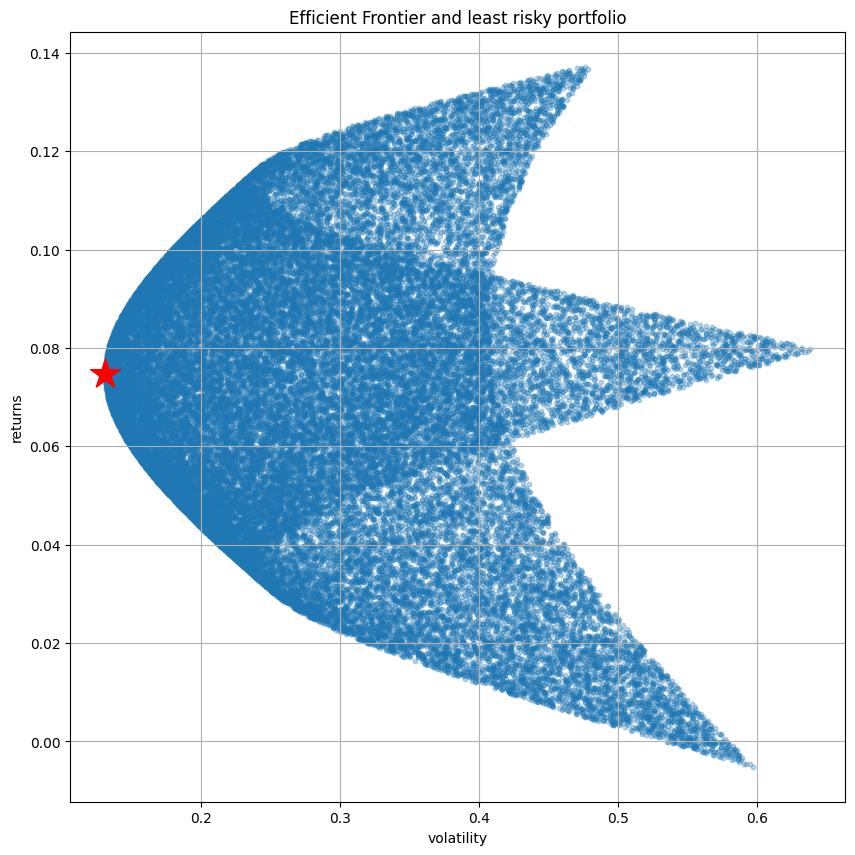

In [ ]:
# Enter current risk free rate
RF = yf.Ticker('^IRX').info['previousClose'] / 100

min_var_port = portfolios.loc[portfolios['volatility'].idxmin()]
min_var_port['sharpe'] = (min_var_port['returns']-RF)/min_var_port['volatility']


portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
            color='r', marker='*', s=500)
plt.title('Efficient Frontier and least risky portfolio');

In [ ]:
min_var_port

returns       0.074629
volatility    0.131186
GLD_weight    0.529959
IBM_weight    0.144761
SPY_weight    0.325280
sharpe        0.162736
Name: 46421, dtype: float64

In [ ]:
portfolios['sharpe'] = (portfolios['returns']-RF)/portfolios['volatility']
sharpe_max = portfolios.loc[portfolios['sharpe'].idxmax()]
sharpe_max

returns       0.108468
volatility    0.209300
GLD_weight    0.454372
IBM_weight   -0.771735
SPY_weight    1.317362
sharpe        0.263680
Name: 32321, dtype: float64

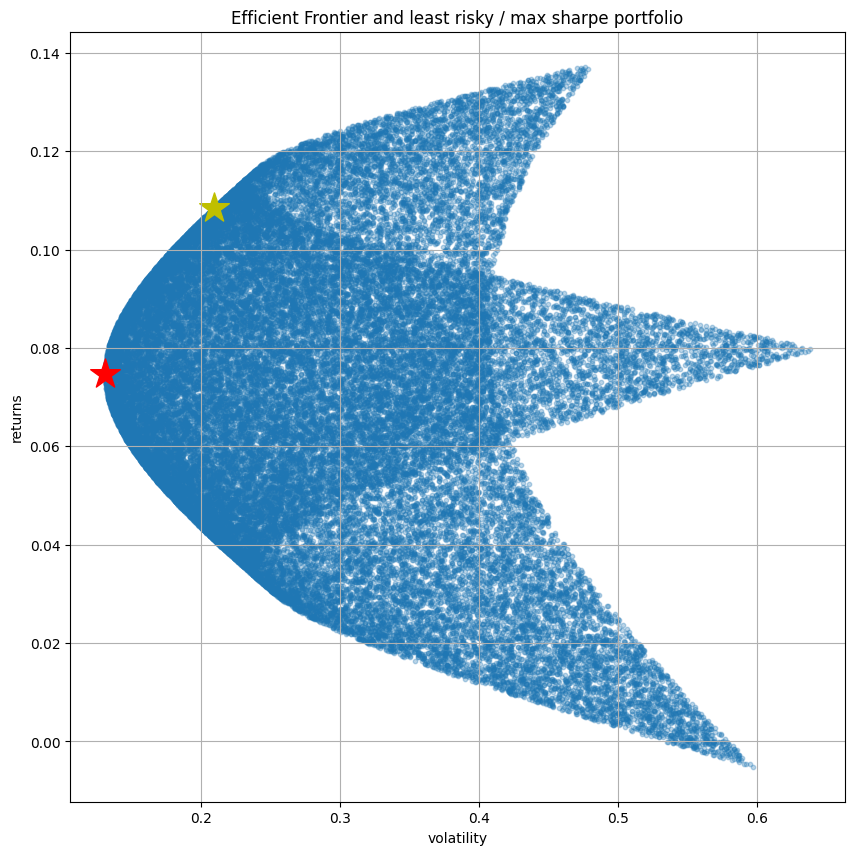

In [ ]:
# plot the
portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
            color='r', marker='*', s=500);
plt.scatter(x=sharpe_max[1],y=sharpe_max[0],\
            color='y', marker='*', s=500);
plt.title('Efficient Frontier and least risky / max sharpe portfolio');